In [1]:
WANDB_DESC = 'Setting up BNAF.'

In [2]:
%%capture
! pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
! pip install wandb

In [3]:
import torch
assert torch.__version__ == '1.9.0+cu102'
! pip list | grep torch

In [4]:
! wandb login

In [5]:
### COLAB ###

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Install missing packages
! apt-get install tree >/dev/null

# Download dataset
# ! ./get_dataset.sh

In [6]:
# Input format of files in $ROOT/data
INPUT_FORMAT = 'Boosted_Jets_Sample-{}.snappy.parquet'

In [7]:
''' DOING IMPORTS '''

import os
import cv2
import wandb
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from tqdm.auto import tqdm, trange
import torch.nn.functional as F


# Set Numpy Print Options
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [8]:
''' CREATE AND SET DATA/CACHE DIRECTORIES '''

ROOT = '/content/drive/My Drive/_GSoC/Normalizing-Flows/'
DATA_ROOT = ROOT + "data/"
CACHE_ROOT = ROOT + "cache/"
LOGS_ROOT = ROOT + "logs/"

os.chdir(ROOT)
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(CACHE_ROOT, exist_ok=True)
os.makedirs(LOGS_ROOT, exist_ok=True)

# Initialize scratch space on /content for faster read-write
SCRATCH_ROOT = '/content/scratch/'   
os.makedirs(SCRATCH_ROOT, exist_ok=True) 

# print('Directory Structure [Excluding Log/Temp Files]:')
! tree -I 'model*|temp__*|wandb*|run_'

In [9]:
import torch
from torch.utils.data import *

class ParquetDataset(Dataset):
    def __init__(self, filename, channels=[1], max_instances=1024):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None 
        self.verbose = False
        self.channels = channels  # Channels to process - currently only Ecal. 
        self.max_instances = max_instances  # Number of hits to force in each jet.
        
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jets'] = np.float32(data['X_jets'][0]) 
        data['X_jets'] = data['X_jets'][0:]
        data['X_jets'][data['X_jets'] < 1.e-3] = 0.     # Zero-Suppression
        jets = [self.parse_img(dict(data)['X_jets'][i]) for i in self.channels]
        jets = jets[0]            # Temporary Hack for Ecal
        return jets
    
    def __len__(self):
        return self.parquet.num_row_groups

    def parse_img(self, track_img, reduce=False):
        '''
        Returns non-zero hits from the single-channel input jet image - `track_img`. 
        If `max_instances` is defined then returns an array of shape [max_instances, 3].   
        Else returns an array of shape [N, 3] where N is the number of non-zero hits in each jet.
        '''
        track_img = torch.Tensor(track_img)        
        x_pos, y_pos = torch.nonzero(track_img, as_tuple=True)
        val = track_img[x_pos, y_pos]
        out = torch.stack((x_pos,y_pos),dim=1)
        # print(out.shape)

        if self.max_instances:
            # Pad instances with fewer hits
            if out.shape[0] <= self.max_instances:
                pad_len = self.max_instances - out.shape[0]
                out = F.pad(out, pad=(0, 0, 0, pad_len), mode='constant', value=0)
            # Cut off excess hits from other jets
            else:
                out = out[:self.max_instances,:]
        
        if self.verbose:
            print('Output Shape:', out.shape)
        return out

In [10]:
def vis(arr, is_parsed=True, title=None, scale=1000, cmap='gist_heat', reduce=False):  
    '''
    Visualise a jet instance.
    '''

    if not is_parsed:   
        arr = parse_img(arr, reduce)

    x_pos, y_pos, val = arr[:,0], arr[:,1], arr[:,2]

    if scale:
        sz = np.array(np.abs(val)) * scale
    else:
        sz = np.ones_like(val) * 10
        
    plt.figure(figsize=[10,6], facecolor='#f0f0f0')
    cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
    sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 126)
    plt.ylim(0, 126)
    plt.xticks(range(0,125,25))
    plt.yticks(range(0,125,25))
    plt.grid()
    if title:
        plt.title(title)
    plt.show()

In [11]:
dataset_file = DATA_ROOT + INPUT_FORMAT.format(0)
dataset = ParquetDataset(dataset_file, max_instances=None)
dataset.verbose = True
print('Length of Dataset: ', dataset.__len__())

In [12]:
data_sample = dataset.__getitem__(1)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset

import math
import os
import time
import argparse
import pprint
from functools import partial

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action='store_true', help='Train a flow.')
    parser.add_argument('--plot', action='store_false', help='Plot a flow and target density.')
    parser.add_argument('--restore_file', type=str, help='Path to model to restore.')
    parser.add_argument('--output_dir', default='./results/run_')
    parser.add_argument('--cuda', type=int, help='Which GPU to run on.')
    parser.add_argument('--seed', type=int, default=0, help='Random seed.')
    # model parameters
    parser.add_argument('--data_dim', type=int, default=2, help='Dimension of the data.')
    parser.add_argument('--hidden_dim', type=int, default=100, help='Dimensions of hidden layers.')
    parser.add_argument('--n_hidden', type=int, default=3, help='Number of hidden layers.')
    # training parameters
    parser.add_argument('--step', type=int, default=0, help='Current step of training (number of minibatches processed).')
    parser.add_argument('--n_steps', type=int, default=1, help='Number of steps to train.')
    parser.add_argument('--batch_size', type=int, default=200, help='Training batch size.')
    parser.add_argument('--lr', type=float, default=1e-1, help='Initial learning rate.')
    parser.add_argument('--lr_decay', type=float, default=0.5, help='Learning rate decay.')
    parser.add_argument('--lr_patience', type=float, default=2000, help='Number of steps before decaying learning rate.')
    parser.add_argument('--log_interval', type=int, default=50, help='How often to save model and samples.')

    args = parser.parse_args([])
    args.output_dir = os.path.join('./results/run_', time.strftime('%Y-%m-%d_%H-%M-%S', time.gmtime()))
    if not os.path.isdir(args.output_dir): 
        os.makedirs(args.output_dir)
    args.device = torch.device('cuda:{}'.format(args.cuda) if args.cuda is not None and torch.cuda.is_available() else 'cpu')

    return args

In [15]:
d = [1,2,3,4,5]
d = torch.Tensor(d)
d = d.type(torch.int)
d = d.type(torch.float32)
d
# d.dtype

tensor([1., 2., 3., 4., 5.])

In [16]:
''' Model components ''' 

class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, data_dim):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.data_dim = data_dim
        # print(self.in_features, self.out_features, self.data_dim)

        # Notation:
        # BNAF weight calculation for (eq 8): W = g(W) * M_d + W * M_o
        #   where W is block lower triangular so model is autoregressive,
        #         g = exp function; M_d is block diagonal mask; M_o is block off-diagonal mask.
        # Weight Normalization (Salimans & Kingma, eq 2): w = g * v / ||v||
        #   where g is scalar, v is k-dim vector, ||v|| is Euclidean norm
        # ------
        # Here: pre-weight norm matrix is v; then: v = exp(weight) * mask_d + weight * mask_o
        #       weight-norm scalar is g: out_features dimensional vector (here logg is used instead to avoid taking logs in the logdet calc.
        #       then weight-normed weight matrix is w = g * v / ||v||
        #
        #       log det jacobian of block lower triangular is taking block diagonal mask of
        #           log(g*v/||v||) = log(g) + log(v) - log(||v||)
        #                          = log(g) + weight - log(||v||) since v = exp(weight) * mask_d + weight * mask_o

        weight = torch.zeros(out_features, in_features)
        mask_d = torch.zeros_like(weight)
        mask_o = torch.zeros_like(weight)
        for i in range(data_dim):
            # select block slices
            h     = slice(i * out_features // data_dim, (i+1) * out_features // data_dim)
            w     = slice(i * in_features // data_dim,  (i+1) * in_features // data_dim)
            w_row = slice(0,                            (i+1) * in_features // data_dim)
            # initialize block-lower-triangular weight and construct block diagonal mask_d and lower triangular mask_o
            nn.init.kaiming_uniform_(weight[h,w_row], a=math.sqrt(5))  # default nn.Linear weight init only block-wise
            mask_d[h,w] = 1
            mask_o[h,w_row] = 1

        mask_o = mask_o - mask_d  # remove diagonal so mask_o is lower triangular 1-off the diagonal

        self.weight = nn.Parameter(weight)                          # pre-mask, pre-weight-norm
        self.logg = nn.Parameter(torch.rand(out_features, 1).log()) # weight-norm parameter
        self.bias = nn.Parameter(nn.init.uniform_(torch.rand(out_features), -1/math.sqrt(in_features), 1/math.sqrt(in_features)))  # default nn.Linear bias init
        self.register_buffer('mask_d', mask_d)
        self.register_buffer('mask_o', mask_o)

    def forward(self, x, sum_logdets):
        # 1. compute BNAF masked weight eq 8
        v = self.weight.exp() * self.mask_d + self.weight * self.mask_o
        # 2. weight normalization
        v_norm = v.norm(p=2, dim=1, keepdim=True)
        w = self.logg.exp() * v / v_norm
        # 3. compute output and logdet of the layer
        # print(x.dtype)
        # print(w.dtype)
        # print(x)
        # print(w)
        x = x.type(torch.float32)
        # print(x.dtype)
        out = F.linear(x, w, self.bias)
        # print('Out:', out.shape)


        logdet = self.logg + self.weight - 0.5 * v_norm.pow(2).log()
        logdet = logdet[self.mask_d.byte()]
        logdet = logdet.view(1, self.data_dim, out.shape[1]//self.data_dim, x.shape[1]//self.data_dim) \
                       .expand(x.shape[0],-1,-1,-1)  # output (B, data_dim, out_dim // data_dim, in_dim // data_dim)

        # 4. sum with sum_logdets from layers before (BNAF section 3.3)
        # Compute log det jacobian of the flow (eq 9, 10, 11) using log-matrix multiplication of the different layers.
        # Specifically for two successive MaskedLinear layers A -> B with logdets A and B of shapes
        #  logdet A is (B, data_dim, outA_dim, inA_dim)
        #  logdet B is (B, data_dim, outB_dim, inB_dim) where outA_dim = inB_dim
        #
        #  Note -- in the first layer, inA_dim = in_features//data_dim = 1 since in_features == data_dim.
        #            thus logdet A is (B, data_dim, outA_dim, 1)
        #
        #  Then:
        #  logsumexp(A.transpose(2,3) + B) = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, inB_dim) , dim=-1)
        #                                  = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, outA_dim), dim=-1)
        #                                  = logsumexp( (B, data_dim, outB_dim, outA_dim), dim=-1) where dim2 of tensor1 is broadcasted
        #                                  = (B, data_dim, outB_dim, 1)

        sum_logdets = torch.logsumexp(sum_logdets.transpose(2,3) + logdet, dim=-1, keepdim=True)

        return out, sum_logdets


    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class Tanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sum_logdets):
        # derivation of logdet:
        # d/dx tanh = 1 / cosh^2; cosh = (1 + exp(-2x)) / (2*exp(-x))
        # log d/dx tanh = - 2 * log cosh = -2 * (x - log 2 + log(1 + exp(-2x)))
        logdet = -2 * (x - math.log(2) + F.softplus(-2*x))
        sum_logdets = sum_logdets + logdet.view_as(sum_logdets)
        return x.tanh(), sum_logdets

class FlowSequential(nn.Sequential):
    """ Container for layers of a normalizing flow """
    def forward(self, x):
        sum_logdets = torch.zeros(1, x.shape[1], 1, 1, device=x.device)
        for module in self:
            x, sum_logdets = module(x, sum_logdets)
        return x, sum_logdets.squeeze()

In [17]:
''' Model '''

class BNAF(nn.Module):
    def __init__(self, data_dim, n_hidden, hidden_dim):
        super().__init__()

        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(data_dim))
        self.register_buffer('base_dist_var', torch.ones(data_dim))

        # construct model
        modules = []
        modules += [MaskedLinear(data_dim, hidden_dim, data_dim), Tanh()]
        for _ in range(n_hidden):
            modules += [MaskedLinear(hidden_dim, hidden_dim, data_dim), Tanh()]
        modules += [MaskedLinear(hidden_dim, data_dim, data_dim)]
        self.net = FlowSequential(*modules)

        # TODO --   add permutation
        #           add residual gate
        #           add stack of flows

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):
        return self.net(x)

def compute_kl_pq_loss(model, input_data):
    input_data = input_data.to(model.base_dist.loc.device)
    z, logdet = model(input_data)
    return - torch.sum(model.base_dist.log_prob(z) + logdet, dim=1)

In [18]:
''' Training ''' 

def train_flow(model, dataset, loss_fn, optimizer, scheduler, args):
    model.train()

    for idx in range(args.n_steps):
        args.step += 1

        input_data = dataset.__getitem__(idx)
        input_data = input_data.reshape(1,-1)
        loss = loss_fn(model, input_data).mean(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        print("Step: {:03d}/{:03d} | Loss: {:14.2f}".format(args.step, args.n_steps, loss.item()))
        wandb.log({'Step': args.step, 'Loss': loss.item()})

        if args.step % args.log_interval == 0:
            # save model
            torch.save({'step': args.step,
                        'state_dict': model.state_dict()},
                        os.path.join(args.output_dir, 'checkpoint.pt'))
            torch.save({'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict()},
                        os.path.join(args.output_dir, 'optim_checkpoint.pt'))

In [19]:
# Config to initialize wandb.
DEFAULT_CFG = {
    'model': 'BNAF',
    'root_dir': ROOT,
}

In [20]:
import warnings
warnings.filterwarnings('ignore')

# Get Args
args = get_args()

# Set custom args
args.data_dim = 2048
args.hidden_dim = 2048   #3072
args.n_steps = 500
args.log_interval = 200
args.cuda = 0
args.lr = 0.3
args.step = 0

# Set Seeds
torch.manual_seed(args.seed)
if args.device.type == 'cuda': 
    torch.cuda.manual_seed(args.seed)

# Get Model
model = BNAF(args.data_dim, args.n_hidden, args.hidden_dim).to(args.device)
if args.restore_file:
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    args.step = model_checkpoint['step']

# Save Config
config = 'Parsed args:\n{}\n\n'.format(pprint.pformat(args.__dict__)) + \
            'Num trainable params: {:,.0f}\n\n'.format(sum(p.numel() for p in model.parameters())) + \
            'Model:\n{}'.format(model)

config_path = os.path.join(args.output_dir, 'config.txt')
if not os.path.exists(config_path):
    with open(config_path, 'a') as f:
        print(config, file=f)

# Get Optimizer + Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=args.lr_decay, patience=args.lr_patience, verbose=True)
if args.restore_file:
    optim_checkpoint = torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device)
    optimizer.load_state_dict(optim_checkpoint['optimizer'])
    scheduler.load_state_dict(optim_checkpoint['scheduler'])

# Initialize Dataset 
dataset_file = DATA_ROOT + INPUT_FORMAT.format(0)
dataset = ParquetDataset(dataset_file)

# Define Loss
loss_fn = compute_kl_pq_loss

In [21]:
# Init Wandb
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_NOTES"] = WANDB_DESC
run = wandb.init(project='gnf', config=DEFAULT_CFG, dir=LOGS_ROOT)
wandb.config.update(args)

# Save files for later
! pip freeze > requirements.txt
wandb.save(ROOT + 'requirements.txt')
# wandb.save(config_path)       # TODO: Fix permission issue on Colab.

['/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210702_063355-pbccpm56/files/requirements.txt',
 '/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210702_063355-pbccpm56/files/requirements.txt']

In [22]:
# Train The Model
train_flow(model, dataset, loss_fn, optimizer, scheduler, args)

In [23]:
00

0

In [24]:
def eval_bnaf(model, dataset, instance_idx, verbose=True):
    input_data = dataset.__getitem__(instance_idx)
    zzk, logdets = model(input_data.reshape(1,-1))
    log_prob = model.base_dist.log_prob(zzk) + logdets
    prob = log_prob.sum(1).exp().cpu()
    pred = log_prob.reshape(1024,3).cpu().detach()

    if verbose:
        print('zzk:{}, logdets:{}'.format(zzk.shape, logdets.shape))
        print('zzk:{}, logdets:{}'.format(prob.shape, log_prob.shape))
        print('pred:{}'.format(pred.shape))

    return input_data, pred

input_data, pred = eval_bnaf(model, dataset, instance=0)

In [25]:
def eval_bnaf(model, dataset, instance_idx, verbose=True):
    input_data = dataset.__getitem__(instance_idx)
    zzk, logdets = model(input_data.reshape(1,-1))
    log_prob = model.base_dist.log_prob(zzk) + logdets
    prob = log_prob.sum(1).exp().cpu()
    pred = log_prob.reshape(1024,2).cpu().detach()

    if verbose:
        print('zzk:{}, logdets:{}'.format(zzk.shape, logdets.shape))
        print('zzk:{}, logdets:{}'.format(prob.shape, log_prob.shape))
        print('pred:{}'.format(pred.shape))

    return input_data, pred

input_data, pred = eval_bnaf(model, dataset, instance_idx=0)

In [26]:
vis(input_data)

In [27]:
input_data.shape

torch.Size([1024, 2])

In [28]:
input_data.shape[1]

2

In [29]:
def vis(arr, is_parsed=True, title=None, scale=1000, cmap='gist_heat', reduce=False):  
    '''
    Visualise a jet instance.
    '''

    if not is_parsed:   
        arr = parse_img(arr, reduce)

    if input_data.shape[1] == 2:
        x_pos, y_pos, val = arr[:,0], arr[:,1], arr[:,2]
    else:
        x_pos, y_pos = arr[:,0], arr[:,1]
        val = torch.ones_like(x_pos)
        scale = None

    if scale:
        sz = np.array(np.abs(val)) * scale
    else:
        sz = np.ones_like(val) * 10
        
    plt.figure(figsize=[10,6], facecolor='#f0f0f0')
    cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
    sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 126)
    plt.ylim(0, 126)
    plt.xticks(range(0,125,25))
    plt.yticks(range(0,125,25))
    plt.grid()
    if title:
        plt.title(title)
    plt.show()

In [30]:
vis(input_data)

In [31]:
input_data.shape[2]

In [32]:
input_data.shape[1]

2

In [33]:
def vis(arr, is_parsed=True, title=None, scale=1000, cmap='gist_heat', reduce=False):  
    '''
    Visualise a jet instance.
    '''

    if not is_parsed:   
        arr = parse_img(arr, reduce)

    if input_data.shape[1] == 3:
        x_pos, y_pos, val = arr[:,0], arr[:,1], arr[:,2]
    else:
        x_pos, y_pos = arr[:,0], arr[:,1]
        val = torch.ones_like(x_pos)
        scale = None

    if scale:
        sz = np.array(np.abs(val)) * scale
    else:
        sz = np.ones_like(val) * 10
        
    plt.figure(figsize=[10,6], facecolor='#f0f0f0')
    cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
    sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 126)
    plt.ylim(0, 126)
    plt.xticks(range(0,125,25))
    plt.yticks(range(0,125,25))
    plt.grid()
    if title:
        plt.title(title)
    plt.show()

In [34]:
vis(input_data)

In [35]:
def vis(arr, is_parsed=True, title=None, scale=1000, cmap='gist_heat', reduce=False):  
    '''
    Visualise a jet instance.
    '''

    if not is_parsed:   
        arr = parse_img(arr, reduce)

    if input_data.shape[1] == 3:
        x_pos, y_pos, val = arr[:,0], arr[:,1], arr[:,2]
    elif input_data.shape[1] == 2:
        x_pos, y_pos = arr[:,0], arr[:,1]
        val = torch.ones_like(x_pos)
        scale = None

    if scale:
        sz = np.array(np.abs(val)) * scale
    else:
        sz = np.ones_like(val) * 10
        
    plt.figure(figsize=[10,6], facecolor='#f0f0f0')
    cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
    sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 126)
    plt.ylim(0, 126)
    plt.xticks(range(0,125,25))
    plt.yticks(range(0,125,25))
    plt.grid()
    if title:
        plt.title(title)
    plt.show()

In [36]:
vis(input_data)

In [37]:
def vis(arr, is_parsed=True, title=None, scale=1000, cmap='gist_heat', reduce=False):  
    '''
    Visualise a jet instance.
    '''

    if not is_parsed:   
        arr = parse_img(arr, reduce)

    if arr.shape[1] == 3:
        x_pos, y_pos, val = arr[:,0], arr[:,1], arr[:,2]
    elif arr.shape[1] == 2:
        x_pos, y_pos = arr[:,0], arr[:,1]
        val = torch.ones_like(x_pos)
        scale = None

    if scale:
        sz = np.array(np.abs(val)) * scale
    else:
        sz = np.ones_like(val) * 10
        
    plt.figure(figsize=[10,6], facecolor='#f0f0f0')
    cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
    sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 126)
    plt.ylim(0, 126)
    plt.xticks(range(0,125,25))
    plt.yticks(range(0,125,25))
    plt.grid()
    if title:
        plt.title(title)
    plt.show()

In [38]:
vis(input_data)

In [39]:
arr = input_data


x_pos, y_pos = arr[:,0], arr[:,1]
val = np.ones_like(x_pos)
scale = None

sz = np.ones_like(val) * 10
    
plt.figure(figsize=[10,6], facecolor='#f0f0f0')
cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
plt.colorbar(sc)
plt.xlim(0, 126)
plt.ylim(0, 126)
plt.xticks(range(0,125,25))
plt.yticks(range(0,125,25))
plt.grid()
if title:
    plt.title(title)
plt.show()

In [40]:
arr = input_data


x_pos, y_pos = arr[:,0], arr[:,1]
val = np.ones_like(x_pos)
scale = None

sz = np.ones_like(val) * 10
    
plt.figure(figsize=[10,6], facecolor='#f0f0f0')
cm = plt.cm.get_cmap('gist_heat')     # 'gist_heat' / 'YlOrRd'
sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
plt.colorbar(sc)
plt.xlim(0, 126)
plt.ylim(0, 126)
plt.xticks(range(0,125,25))
plt.yticks(range(0,125,25))
plt.grid()
plt.show()

In [41]:
arr = input_data

x_pos, y_pos = arr[:,0], arr[:,1]
val = np.ones_like(x_pos)
scale = None

sz = np.ones_like(val) * 10
print(x_pos.shape, y_pos.shape, val.shape)

plt.figure(figsize=[10,6], facecolor='#f0f0f0')
cm = plt.cm.get_cmap('gist_heat')     # 'gist_heat' / 'YlOrRd'
sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
plt.colorbar(sc)
plt.xlim(0, 126)
plt.ylim(0, 126)
plt.xticks(range(0,125,25))
plt.yticks(range(0,125,25))
plt.grid()
plt.show()

In [42]:
x_pos

tensor([ 3, 10, 22,  ...,  0,  0,  0])

In [43]:
''' DOING IMPORTS '''

%matplotlib inline

import os
import cv2
import wandb
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from tqdm.auto import tqdm, trange
import torch.nn.functional as F

# Set Numpy Print Options
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [44]:
''' CREATE AND SET DATA/CACHE DIRECTORIES '''

ROOT = '/content/drive/My Drive/_GSoC/Normalizing-Flows/'
DATA_ROOT = ROOT + "data/"
CACHE_ROOT = ROOT + "cache/"
LOGS_ROOT = ROOT + "logs/"

os.chdir(ROOT)
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(CACHE_ROOT, exist_ok=True)
os.makedirs(LOGS_ROOT, exist_ok=True)

# Initialize scratch space on /content for faster read-write
SCRATCH_ROOT = '/content/scratch/'   
os.makedirs(SCRATCH_ROOT, exist_ok=True) 

# print('Directory Structure [Excluding Log/Temp Files]:')
! tree -I 'model*|temp__*|wandb*|run_'

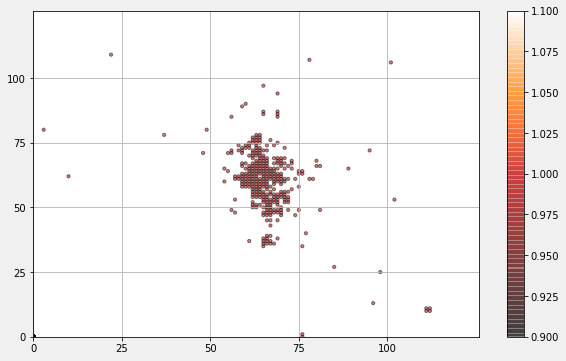

In [45]:
arr = input_data

x_pos, y_pos = arr[:,0], arr[:,1]
val = np.ones_like(x_pos)
scale = None

sz = np.ones_like(val) * 10
print(x_pos.shape, y_pos.shape, val.shape)

plt.figure(figsize=[10,6], facecolor='#f0f0f0')
cm = plt.cm.get_cmap('gist_heat')     # 'gist_heat' / 'YlOrRd'
sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
plt.colorbar(sc)
plt.xlim(0, 126)
plt.ylim(0, 126)
plt.xticks(range(0,125,25))
plt.yticks(range(0,125,25))
plt.grid()
plt.show()

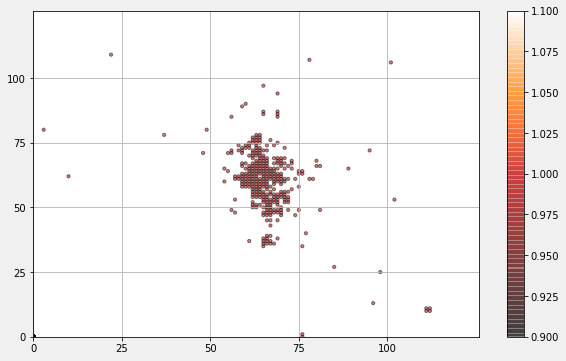

In [46]:
vis(input_data)

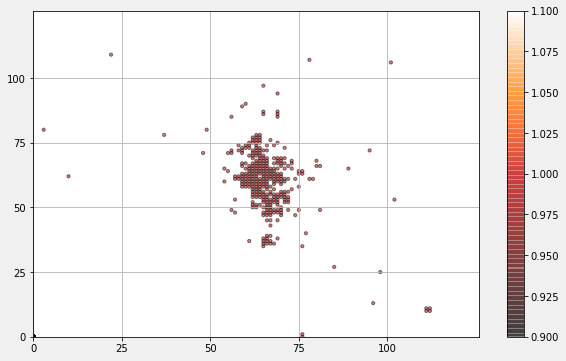

In [47]:
vis(input_data)

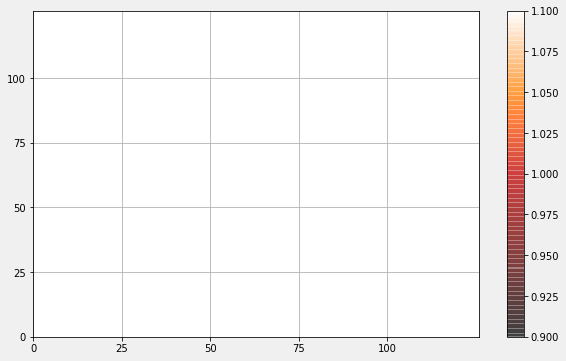

In [48]:
vis(pred)

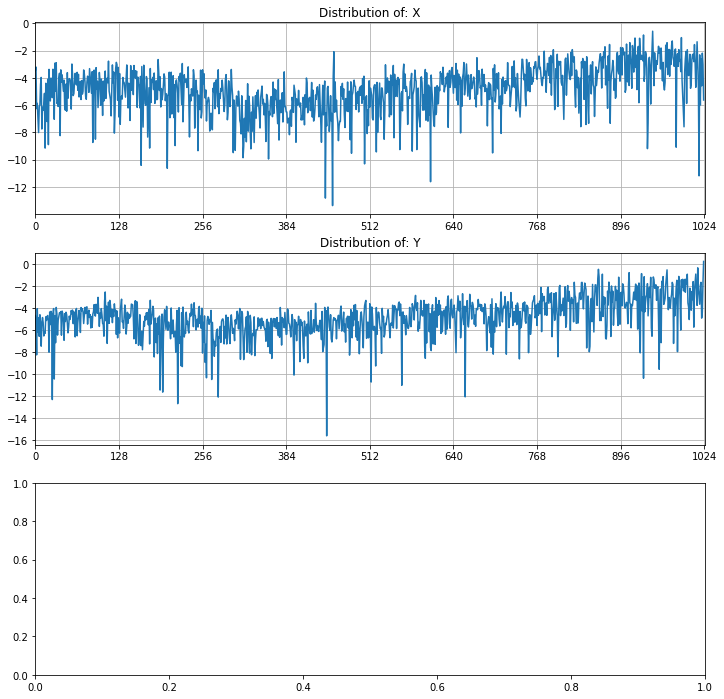

In [49]:
def analyse_prediction(pred):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=[12,12])
    labels = ['X', 'Y', 'Energy']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i])
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
    plt.show()

analyse_prediction(pred)

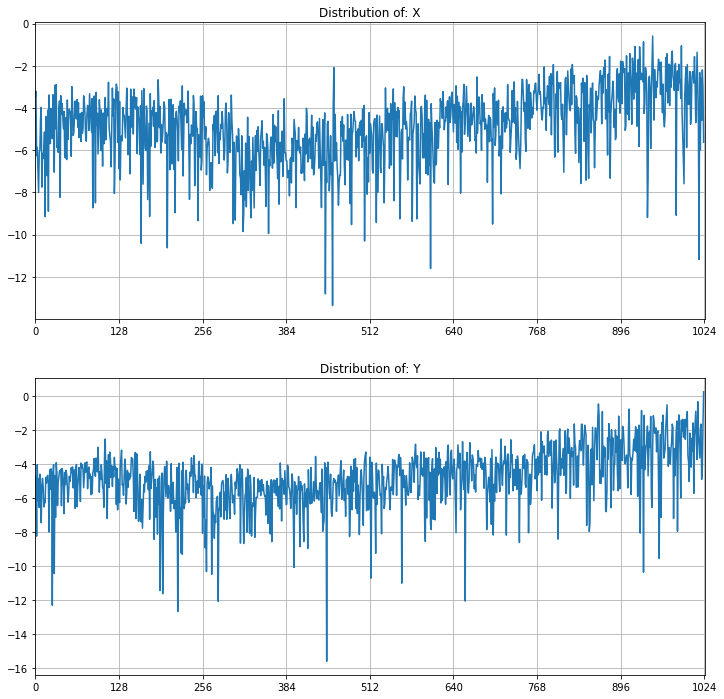

In [50]:
def analyse_prediction(pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i])
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
    plt.show()

analyse_prediction(pred)

In [51]:
p = abs(pred)
print(p)

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
p = scaler.fit_transform(abs(pred)))

print(p)

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
p = scaler.fit_transform(abs(pred))

print(p)

In [54]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# p = scaler.fit_transform(abs(pred))

print(p.max)

In [55]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# p = scaler.fit_transform(abs(pred))

print(p.max(), m.min())

In [56]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# p = scaler.fit_transform(abs(pred))

print(p.max(), p.min())

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
p = scaler.fit_transform(abs(pred))

print(p.max(), p.min())

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
p = scaler.fit_transform(abs(pred)) * 125

print(p.max(), p.min())

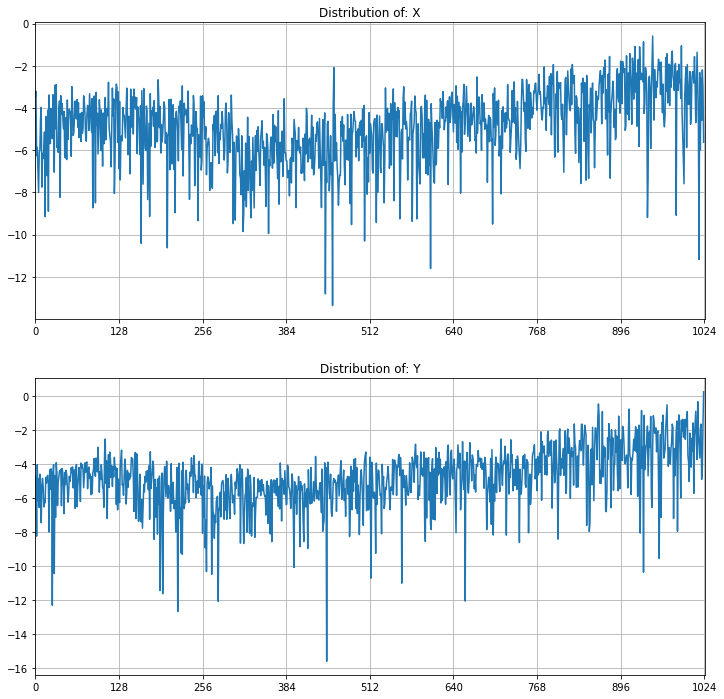

In [59]:
def analyse_prediction(pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i])
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
    plt.show()

analyse_prediction(pred)

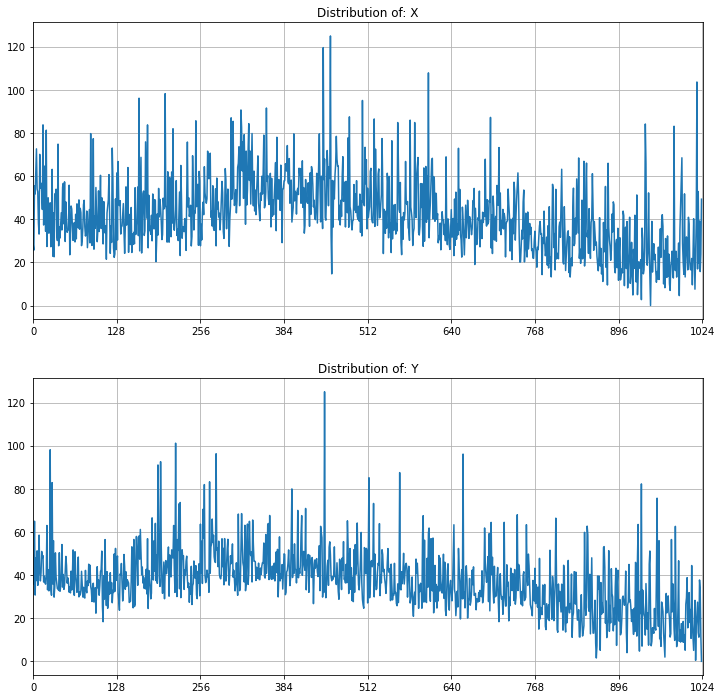

In [60]:
def analyse_prediction(pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i])
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
    plt.show()

analyse_prediction(p)

In [61]:
vis(p)

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
p = scaler.fit_transform(abs(pred)) * 125
p = torch.Tensor(p)

print(p.max(), p.min())

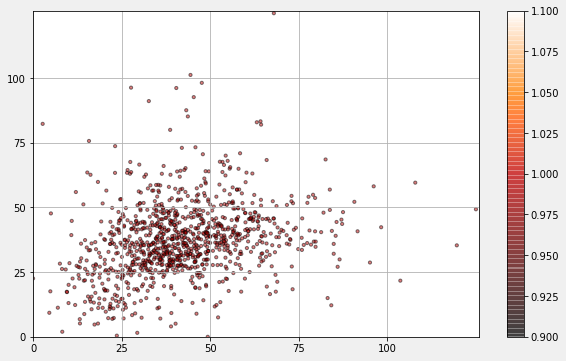

In [63]:
vis(p)

In [64]:
def eval_bnaf(model, dataset, instance_idx, scale=True, verbose=True):
    input_data = dataset.__getitem__(instance_idx)
    zzk, logdets = model(input_data.reshape(1,-1))
    log_prob = model.base_dist.log_prob(zzk) + logdets
    prob = log_prob.sum(1).exp().cpu()
    pred = log_prob.reshape(1024,2).cpu().detach()

    if verbose:
        print('zzk:{}, logdets:{}'.format(zzk.shape, logdets.shape))
        print('zzk:{}, logdets:{}'.format(prob.shape, log_prob.shape))
        print('pred:{}'.format(pred.shape))

    if scale:
        scaler = MinMaxScaler()
        pred = scaler.fit_transform(pred) * 125
        pred = torch.Tensor(pred)

    return input_data, pred

input_data, pred = eval_bnaf(model, dataset, instance_idx=0)

In [65]:
input_data.shape[1]

2

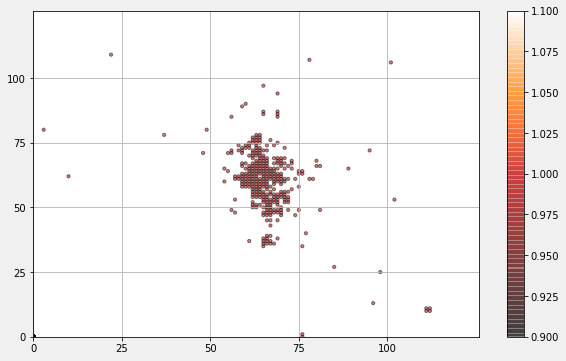

In [66]:
vis(input_data)

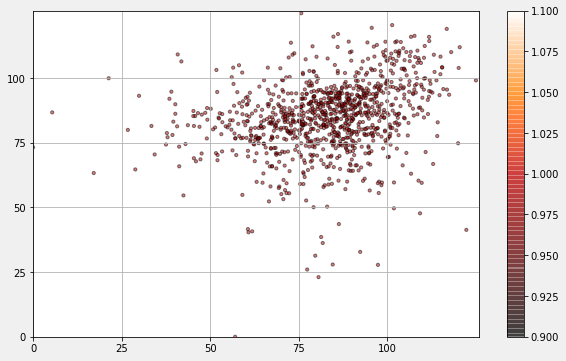

In [67]:
vis(pred)

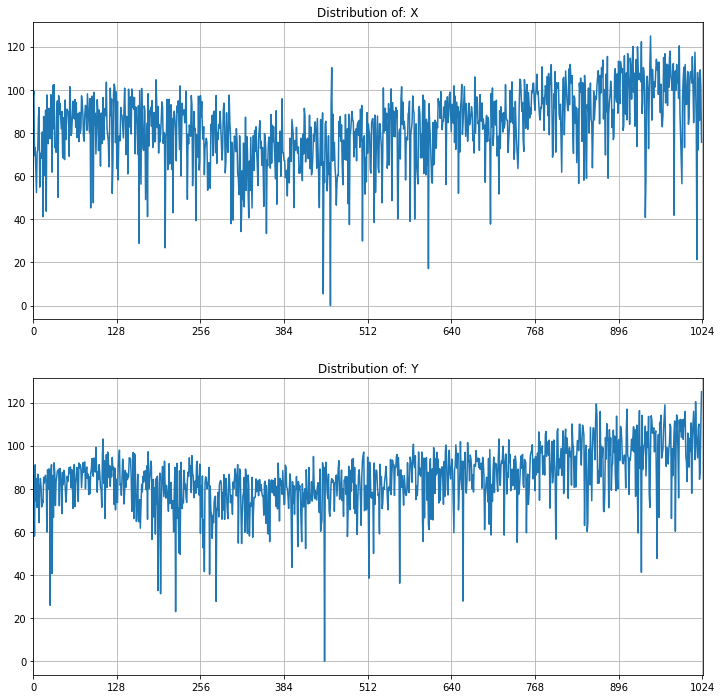

In [68]:
def analyse_prediction(pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i])
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
    plt.show()

analyse_prediction(pred)

In [69]:
from sklearn.preprocessing import MinMaxScaler

def eval_bnaf(model, dataset, instance_idx, scale=True, verbose=True):
    input_data = dataset.__getitem__(instance_idx)
    zzk, logdets = model(input_data.reshape(1,-1))
    log_prob = model.base_dist.log_prob(zzk) + logdets
    prob = log_prob.sum(1).exp().cpu()
    pred = log_prob.reshape(1024,2).cpu().detach()

    if verbose:
        print('zzk:{}, logdets:{}'.format(zzk.shape, logdets.shape))
        print('zzk:{}, logdets:{}'.format(prob.shape, log_prob.shape))
        print('pred:{}'.format(pred.shape))

    if scale:
        scaler = MinMaxScaler()
        pred = scaler.fit_transform(pred) * 125
        pred = torch.Tensor(pred)

    return input_data, pred

input_data, pred = eval_bnaf(model, dataset, instance_idx=1, scale=True)

In [70]:
input_data.shape[1]

2

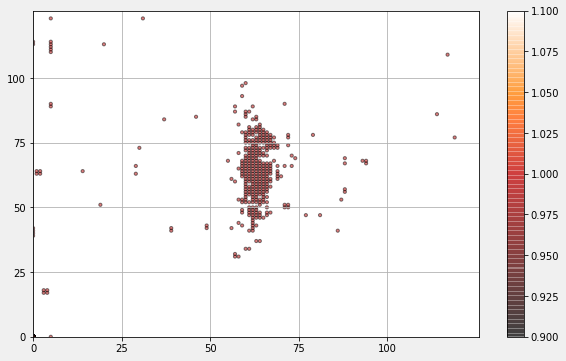

In [71]:
vis(input_data)

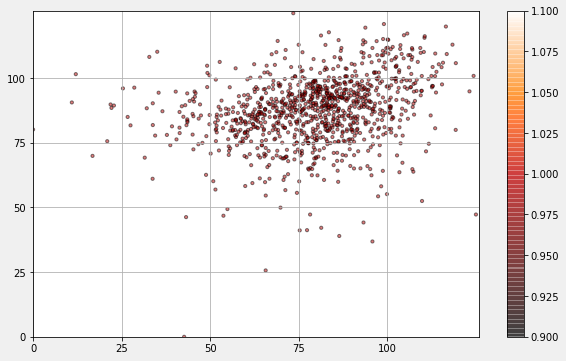

In [72]:
vis(pred)

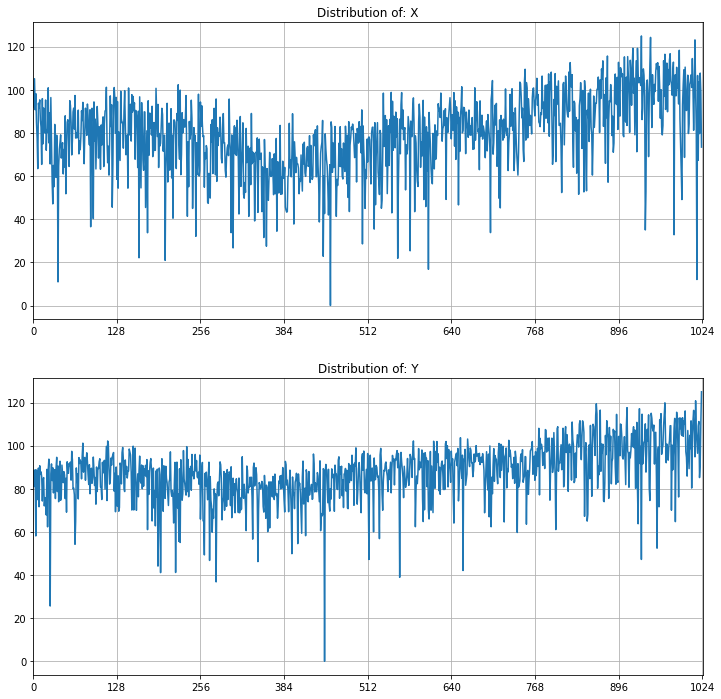

In [73]:
def analyse_prediction(pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i])
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
    plt.show()

analyse_prediction(pred)

In [74]:
def analyse_prediction(input_data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(input_data[:,i], label='labels')
        ax.plot(pred[:,i], label='prediction')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(pred)

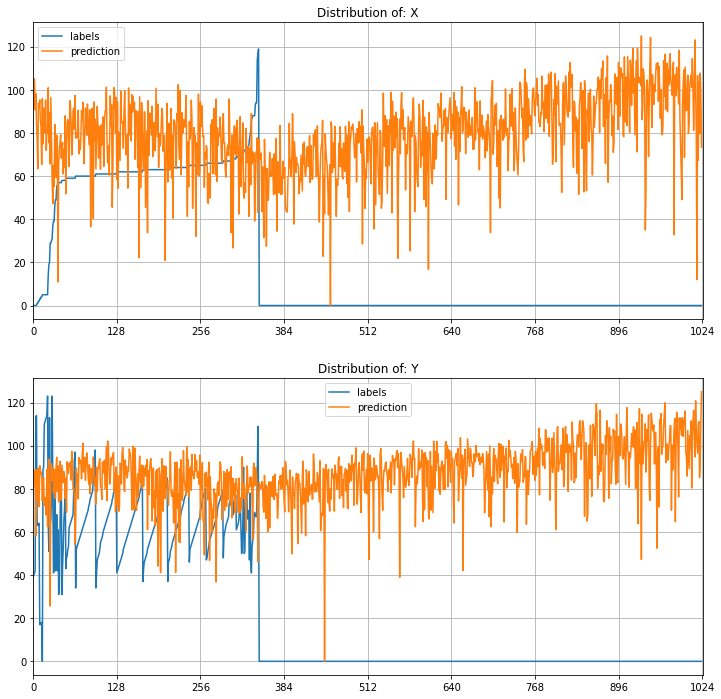

In [75]:
def analyse_prediction(input_data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(input_data[:,i], label='labels')
        ax.plot(pred[:,i], label='prediction')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

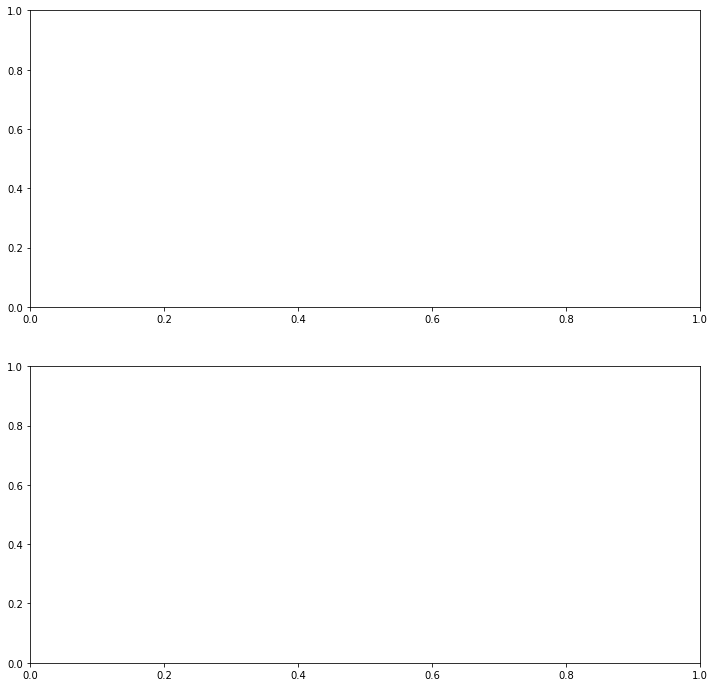

In [76]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i], label='prediction', col='lightskyblue')
        ax.plot(data[:,i], label='labels')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

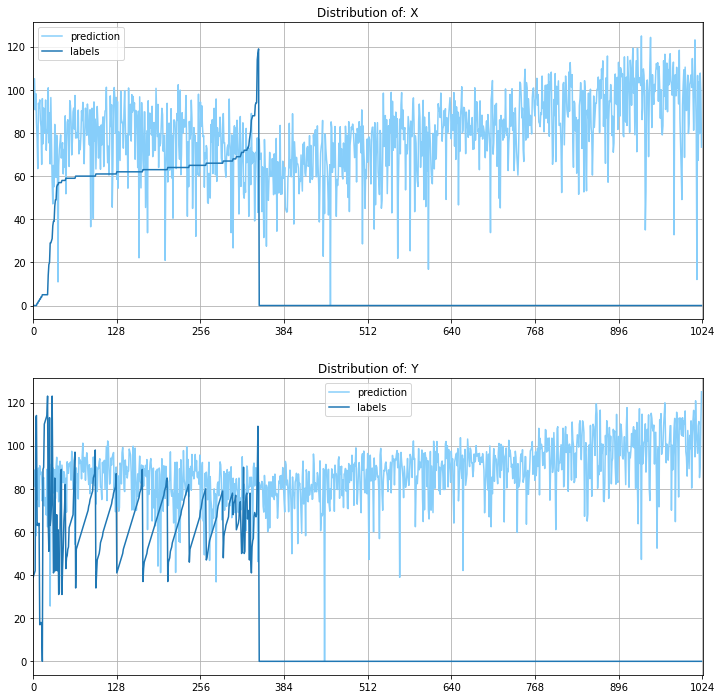

In [77]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data[:,i], label='labels')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

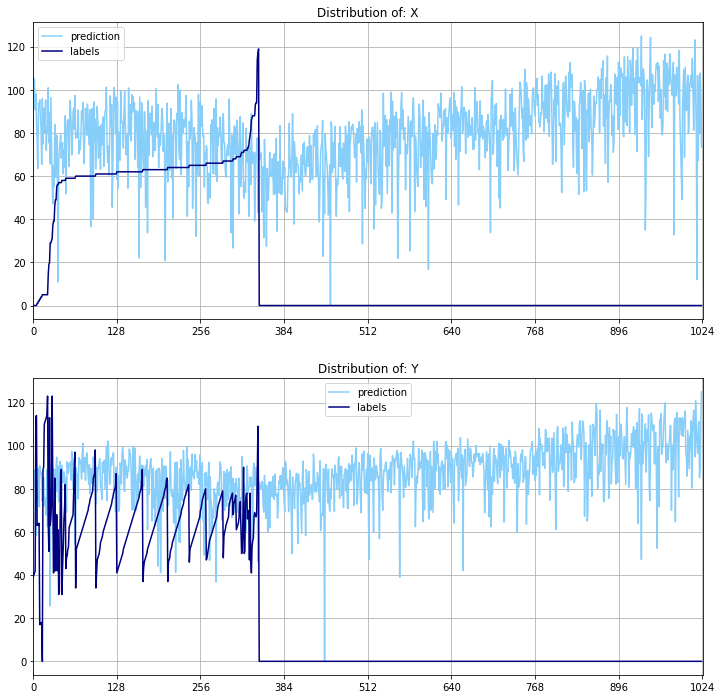

In [78]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

In [79]:
data[:,0]

In [80]:
input_data[:,0]

tensor([0, 0, 0,  ..., 0, 0, 0])

In [81]:
k = [1,2,3,4,0,0,0]
k.nonzero

In [82]:
k = torch.Tensor([1,2,3,4,0,0,0])
k.nonzero

<function Tensor.nonzero>

In [83]:
k = torch.Tensor([1,2,3,4,0,0,0])
k.nonzero()

tensor([[0],
        [1],
        [2],
        [3]])

In [84]:
k = torch.Tensor([1,2,3,4,0,0,0])
len(k.nonzero())

4

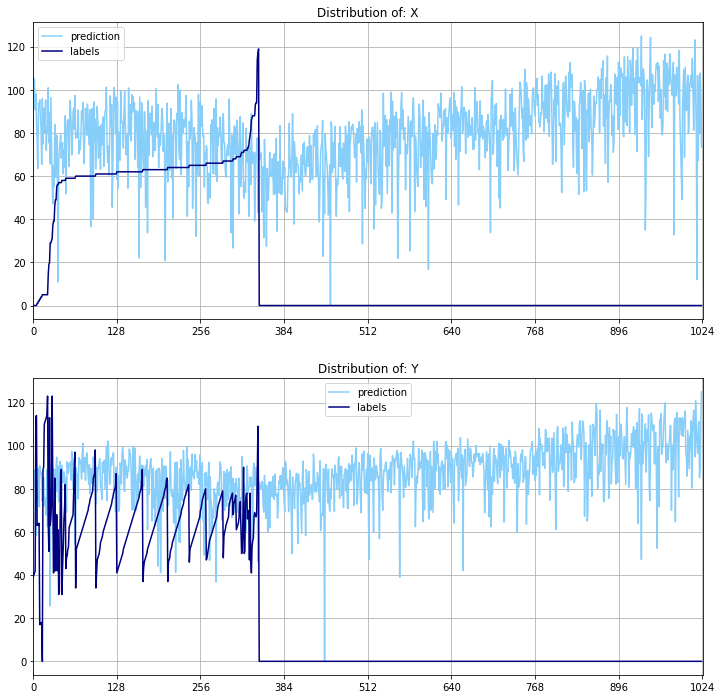

In [85]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']

    for i,ax in enumerate(axes):
        ax.plot(pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

In [86]:
(1024 / 300) * list(range(0,1024))

In [87]:
(1024 / 300) * np.array(range(0,1024))

array([   0.   ,    3.413,    6.827, ..., 3485.013, 3488.427, 3491.84 ])

In [88]:
(1024 / 300) * np.array(range(0,300))

array([   0.   ,    3.413,    6.827,   10.24 ,   13.653,   17.067,
         20.48 ,   23.893,   27.307,   30.72 ,   34.133,   37.547,
         40.96 ,   44.373,   47.787,   51.2  ,   54.613,   58.027,
         61.44 ,   64.853,   68.267,   71.68 ,   75.093,   78.507,
         81.92 ,   85.333,   88.747,   92.16 ,   95.573,   98.987,
        102.4  ,  105.813,  109.227,  112.64 ,  116.053,  119.467,
        122.88 ,  126.293,  129.707,  133.12 ,  136.533,  139.947,
        143.36 ,  146.773,  150.187,  153.6  ,  157.013,  160.427,
        163.84 ,  167.253,  170.667,  174.08 ,  177.493,  180.907,
        184.32 ,  187.733,  191.147,  194.56 ,  197.973,  201.387,
        204.8  ,  208.213,  211.627,  215.04 ,  218.453,  221.867,
        225.28 ,  228.693,  232.107,  235.52 ,  238.933,  242.347,
        245.76 ,  249.173,  252.587,  256.   ,  259.413,  262.827,
        266.24 ,  269.653,  273.067,  276.48 ,  279.893,  283.307,
        286.72 ,  290.133,  293.547,  296.96 ,  300.373,  303.

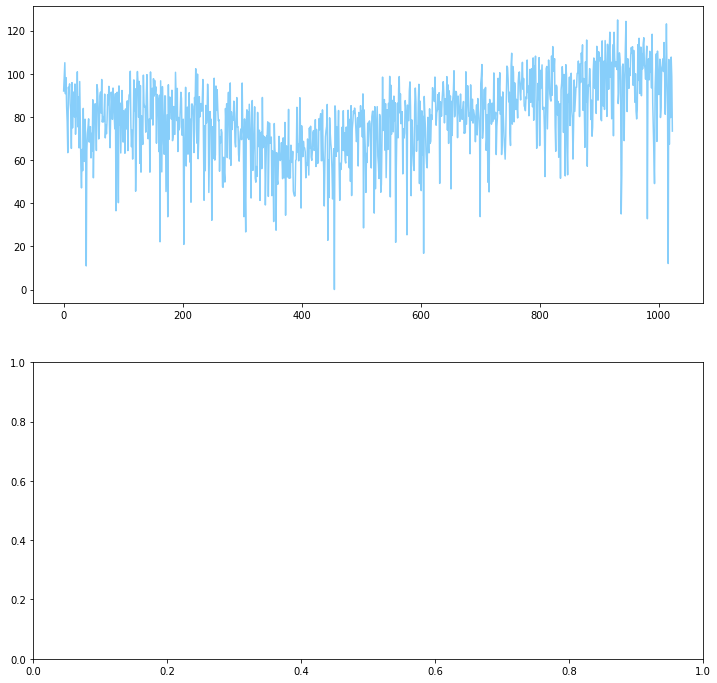

In [89]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

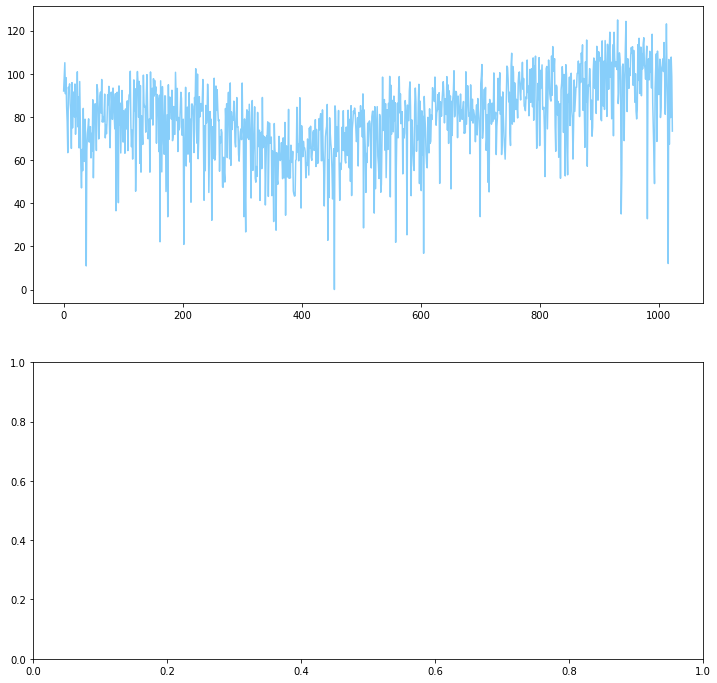

In [90]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    data[data.nonzero()]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

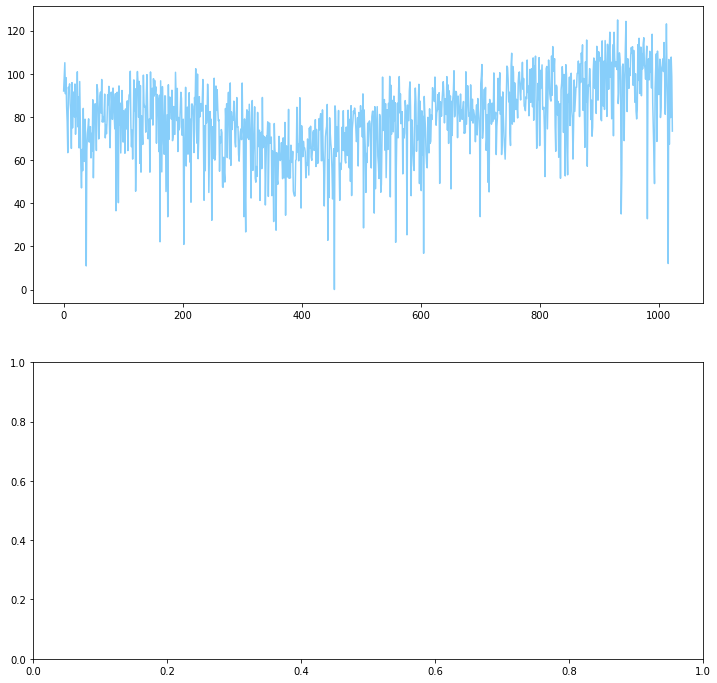

In [91]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    print(n_hits)
    data[data.nonzero()]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

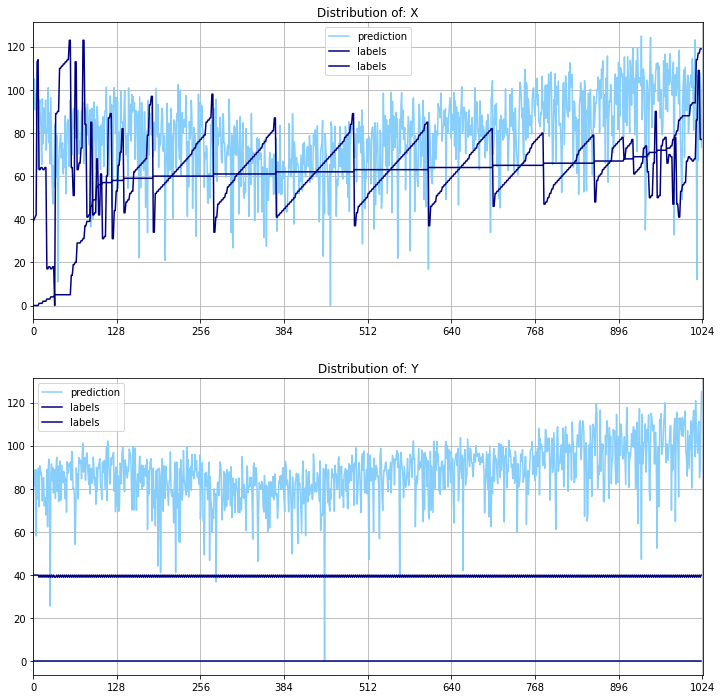

In [92]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    print(n_hits)
    data = data[data.nonzero()]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        print(data_idx.shape, data.shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

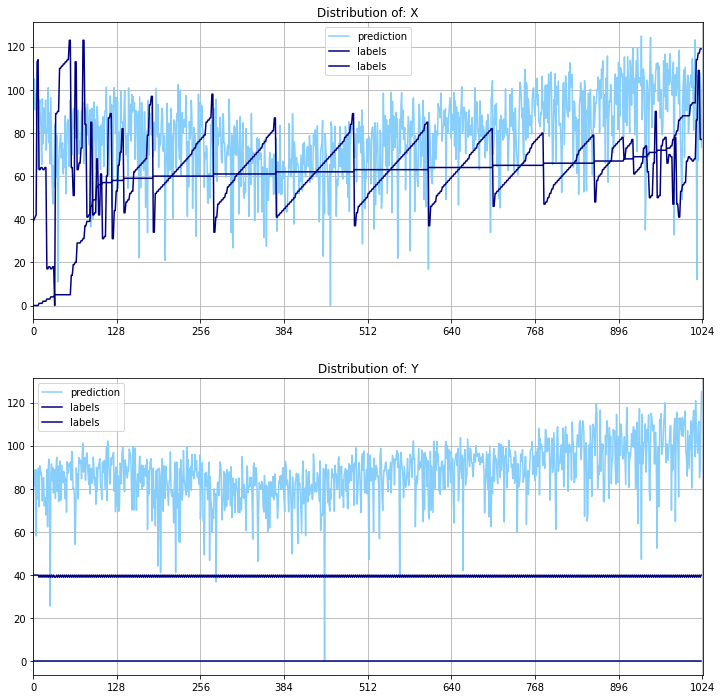

In [93]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    # print(n_hits)
    data = data[data.nonzero()]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        # print(data_idx.shape, data.shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

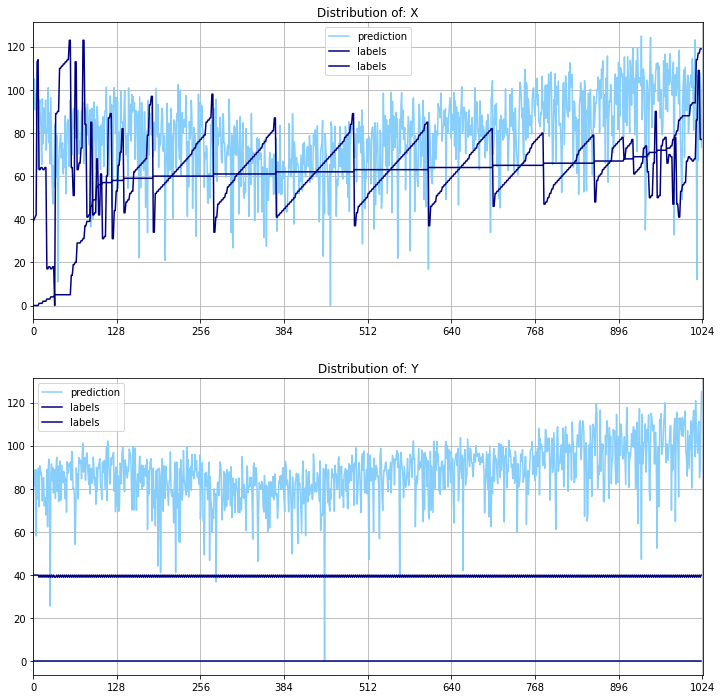

In [94]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    # print(n_hits)
    data = data[data.nonzero()]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        print(data_idx.shape, data.shape)
        print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

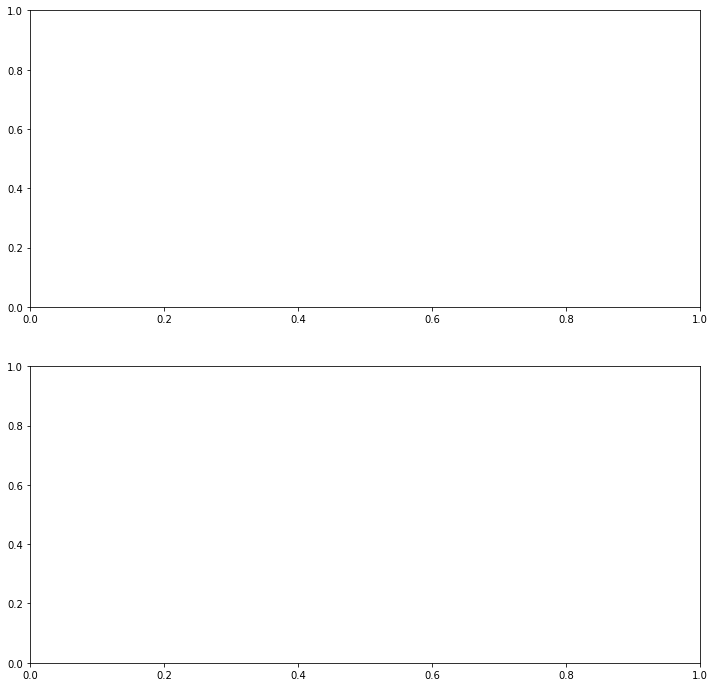

In [95]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    # print(n_hits)
    print(data.shape)
    data = data[data.nonzero()]
    print(data.shape)
    return

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        print(data_idx.shape, data.shape)
        print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

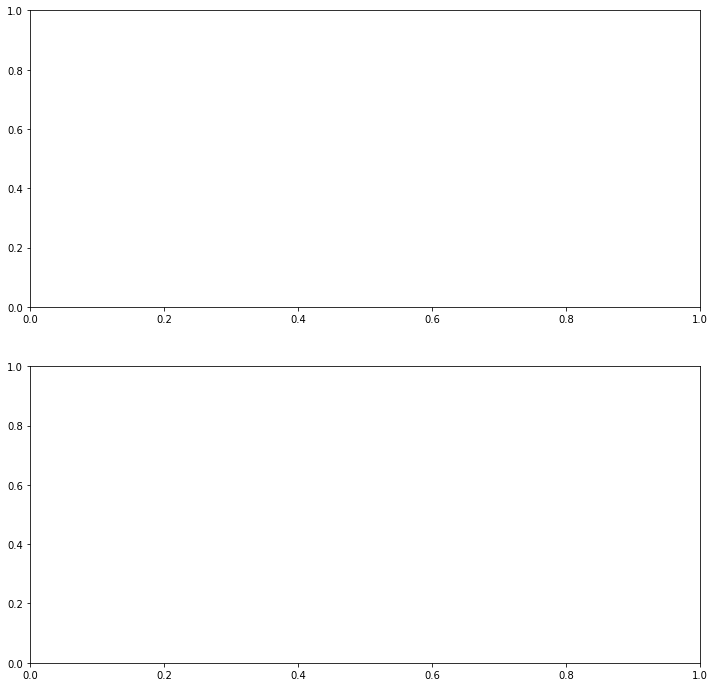

In [96]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    # print(n_hits)
    print(data.shape)
    data = data[:,:data.nonzero()]
    print(data.shape)
    return

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        print(data_idx.shape, data.shape)
        print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

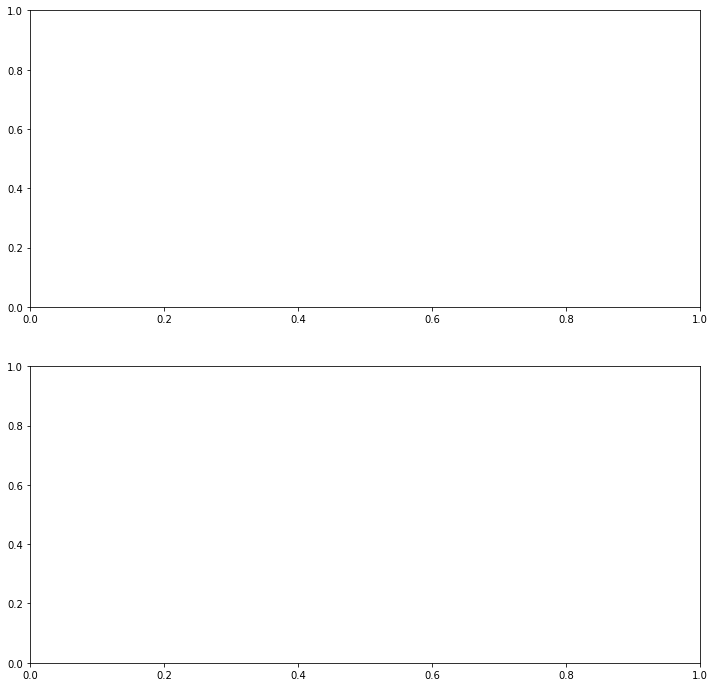

In [97]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    # print(n_hits)
    print(data.shape)
    data = data[:,:n_hits]
    print(data.shape)
    return

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        print(data_idx.shape, data.shape)
        print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

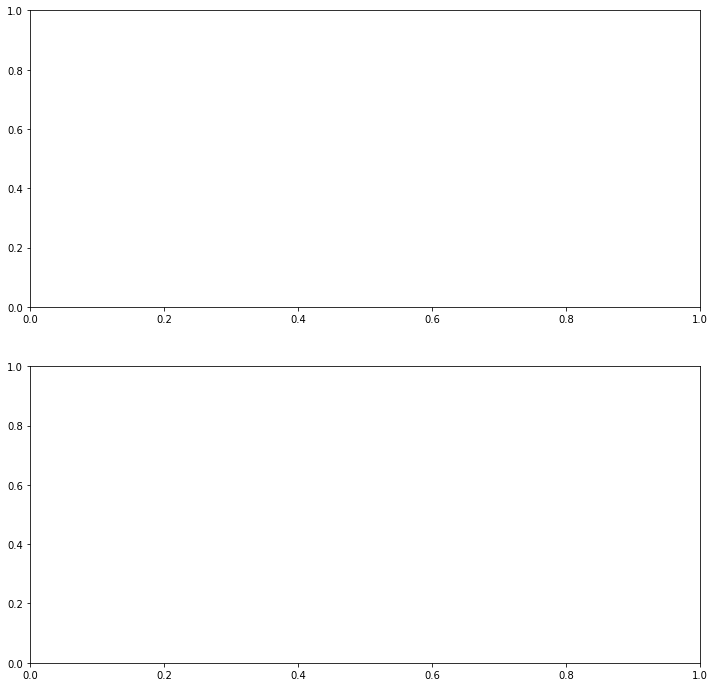

In [98]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    # print(n_hits)
    print(data.shape)
    data = data[:n_hits,:]
    print(data.shape)
    return

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        print(data_idx.shape, data.shape)
        print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

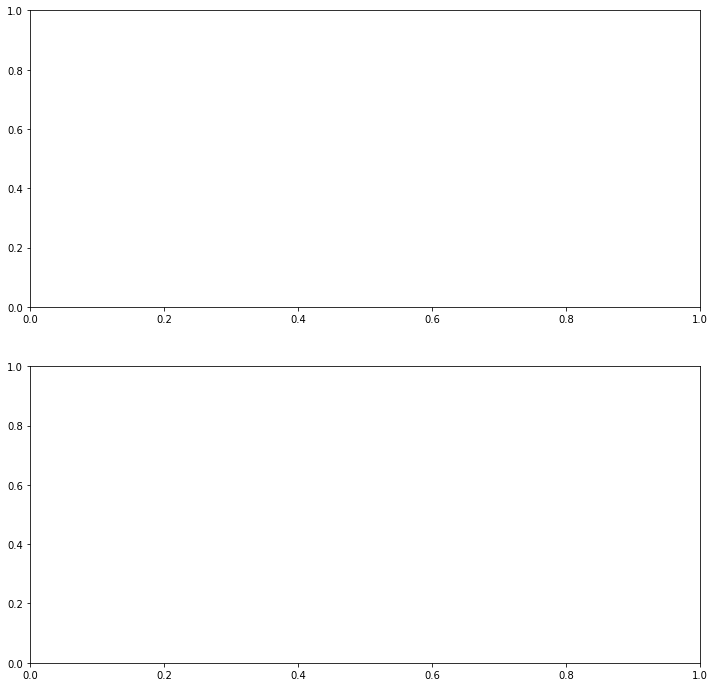

In [99]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    # print(n_hits)
    print(data.shape)
    data = data[:n_hits]
    print(data.shape)
    return

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        print(data_idx.shape, data.shape)
        print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

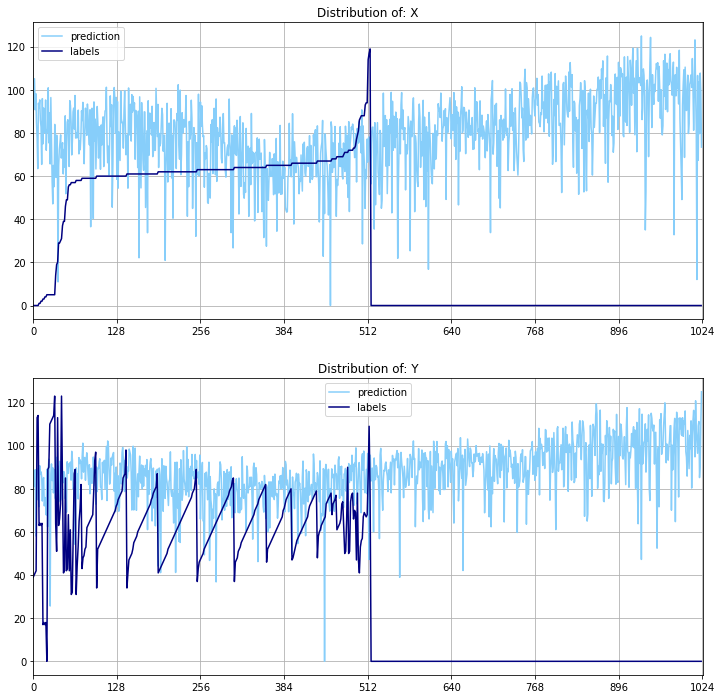

In [100]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    # print(n_hits)
    print(data.shape)
    data = data[:n_hits]
    print(data.shape)
    # return

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        print(data_idx.shape, data.shape)
        print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

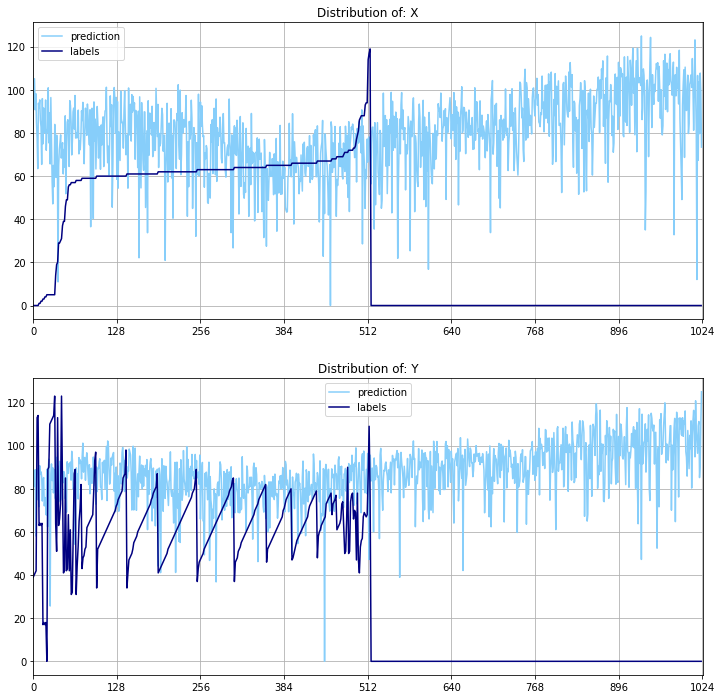

In [101]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero())
    data = data[:n_hits]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        # print(data_idx.shape, data.shape)
        # print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

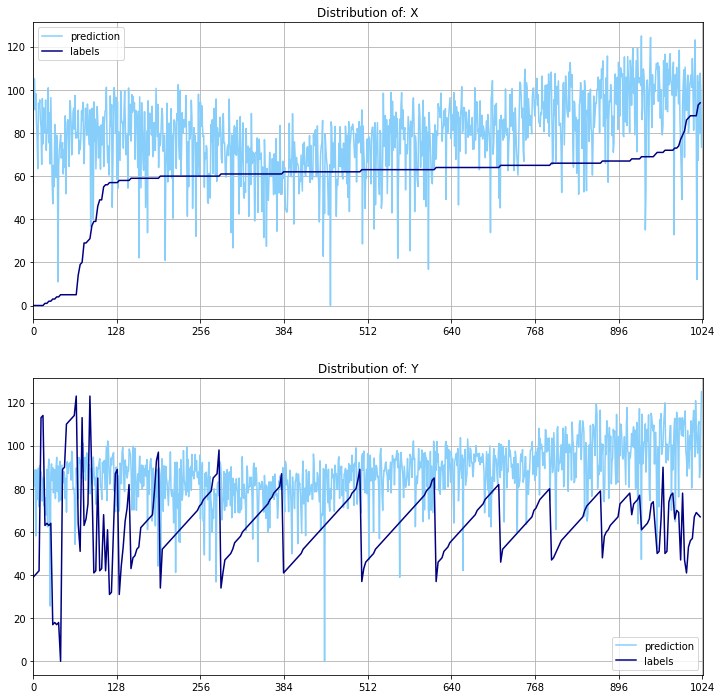

In [102]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero()) // 2
    data = data[:n_hits]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        # print(data_idx.shape, data.shape)
        # print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

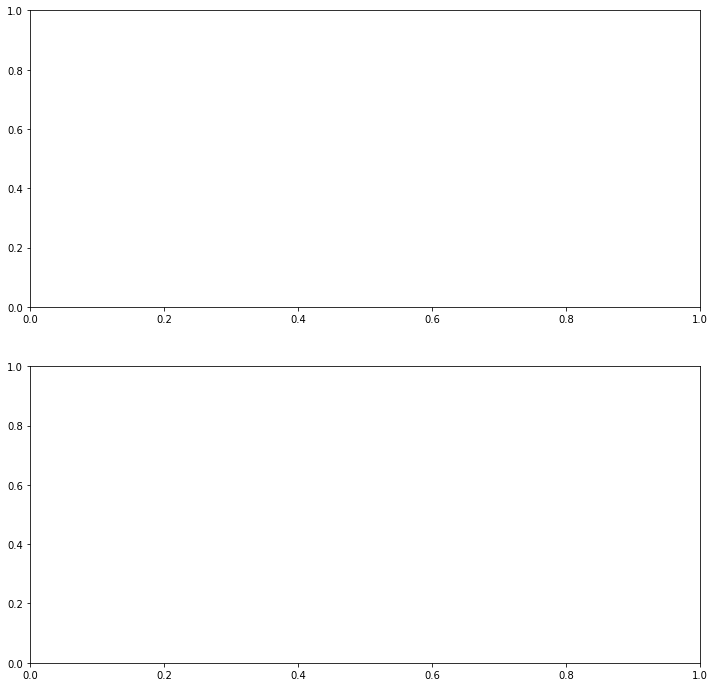

In [103]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero()) / 2
    data = data[:n_hits]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        # print(data_idx.shape, data.shape)
        # print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

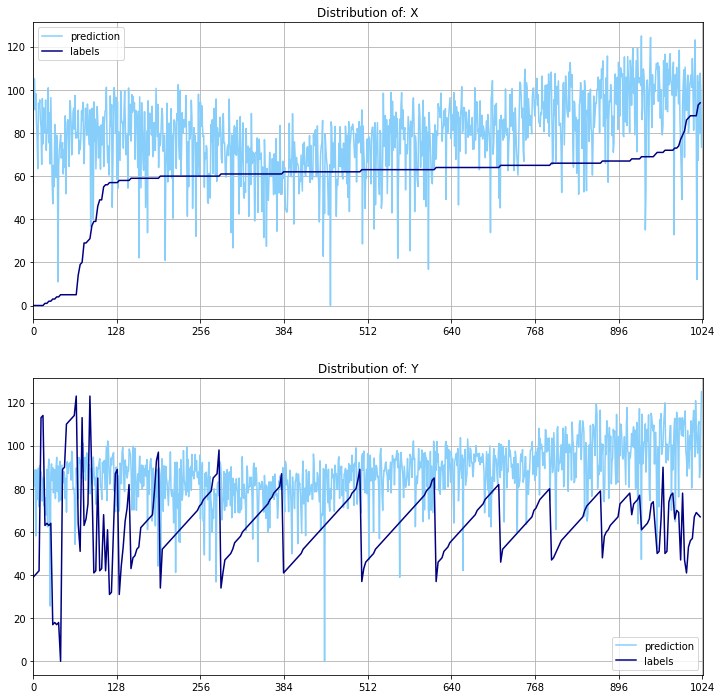

In [104]:
def analyse_prediction(data, pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero()) // 2
    data = data[:n_hits]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))
        # print(data_idx.shape, data.shape)
        # print(pred[:,i].shape, data[:,i].shape)
        ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
        ax.plot(data_idx, data[:,i], label='labels', c='navy')
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)

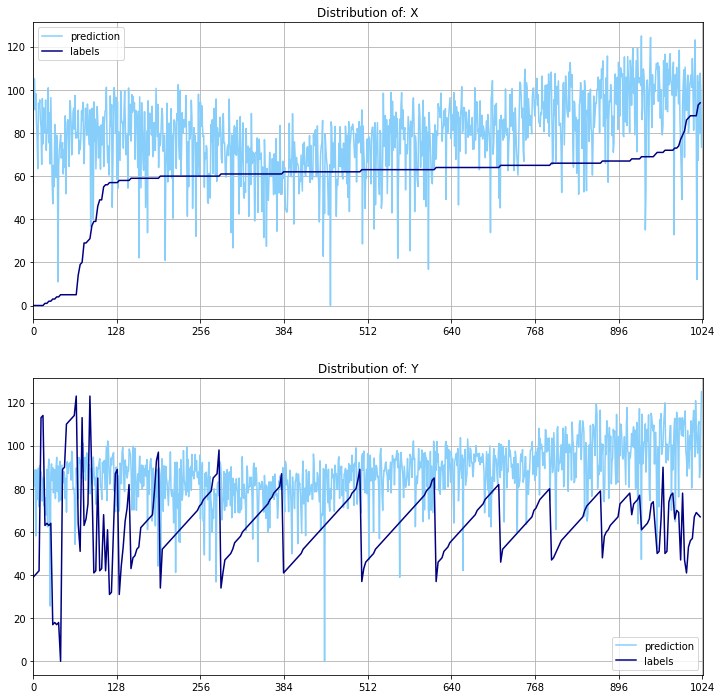

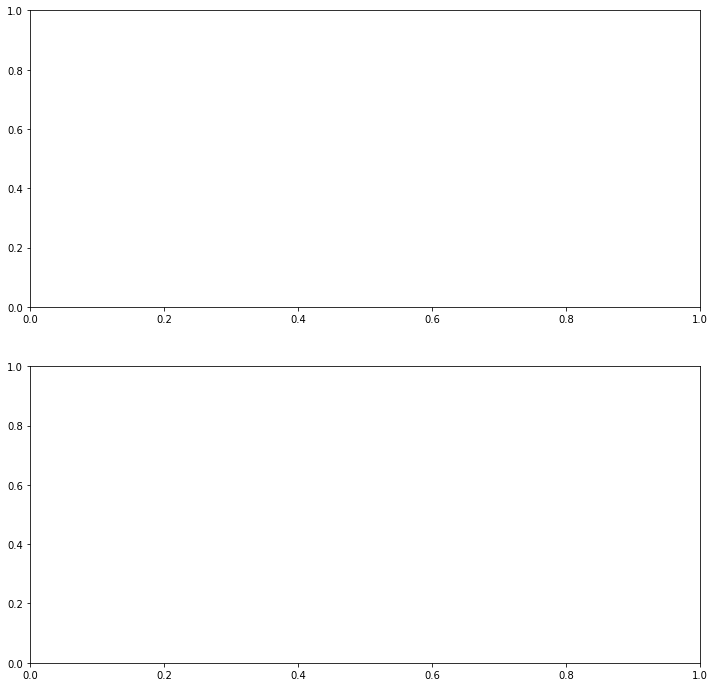

In [105]:
def analyse_prediction(data, pred, sorted=False):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero()) // 2
    data = data[:n_hits]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))

        if sorted:
            ax.plot(pred_idx, sorted(pred[:,i]), label='prediction', c='lightskyblue')
            ax.plot(data_idx, sorted(data[:,i]), label='labels', c='navy')
        else:
            ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
            ax.plot(data_idx, data[:,i], label='labels', c='navy')
        
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)
analyse_prediction(input_data, pred, sorted=True)

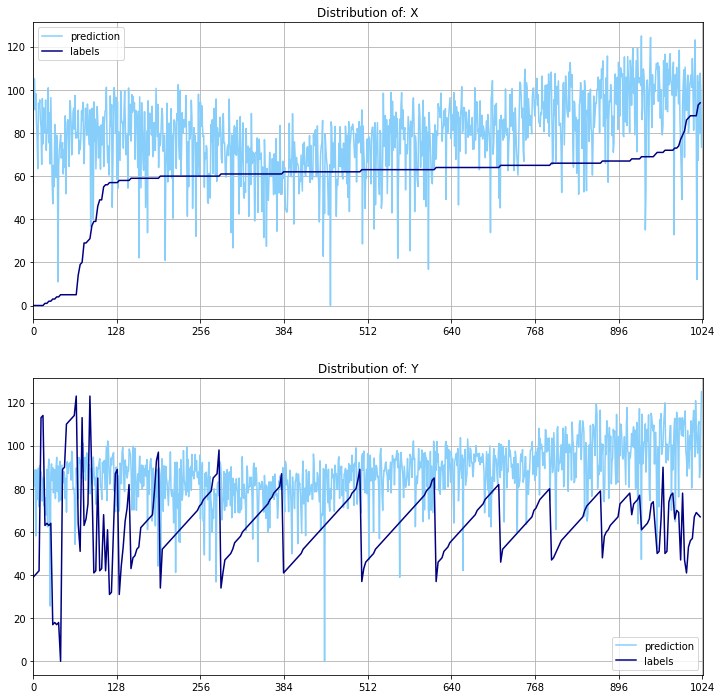

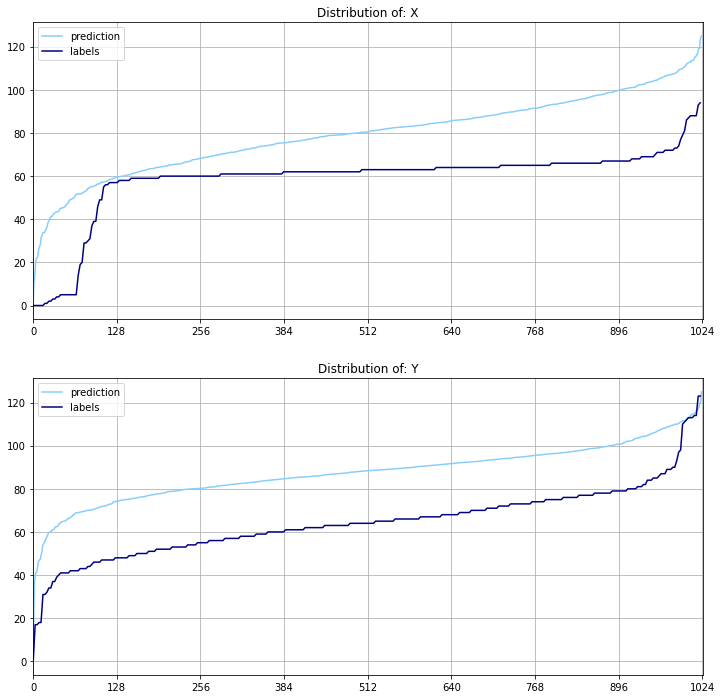

In [106]:
def analyse_prediction(data, pred, to_sort=False):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero()) // 2
    data = data[:n_hits]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))

        if to_sort:
            ax.plot(pred_idx, sorted(pred[:,i]), label='prediction', c='lightskyblue')
            ax.plot(data_idx, sorted(data[:,i]), label='labels', c='navy')
        else:
            ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
            ax.plot(data_idx, data[:,i], label='labels', c='navy')
        
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)
analyse_prediction(input_data, pred, to_sort=True)

In [107]:
from sklearn.preprocessing import MinMaxScaler

def eval_bnaf(model, dataset, instance_idx, scale=True, verbose=True):
    input_data = dataset.__getitem__(instance_idx)
    zzk, logdets = model(input_data.reshape(1,-1))
    log_prob = model.base_dist.log_prob(zzk) + logdets
    prob = log_prob.sum(1).exp().cpu()
    pred = log_prob.reshape(1024,2).cpu().detach()

    if verbose:
        print('zzk:{}, logdets:{}'.format(zzk.shape, logdets.shape))
        print('zzk:{}, logdets:{}'.format(prob.shape, log_prob.shape))
        print('pred:{}'.format(pred.shape))

    if scale:
        scaler = MinMaxScaler()
        pred = scaler.fit_transform(pred) * 125
        pred = torch.Tensor(pred)

    return input_data, pred

input_data, pred = eval_bnaf(model, dataset, instance_idx=0, scale=True)

In [108]:
input_data.shape[1]

2

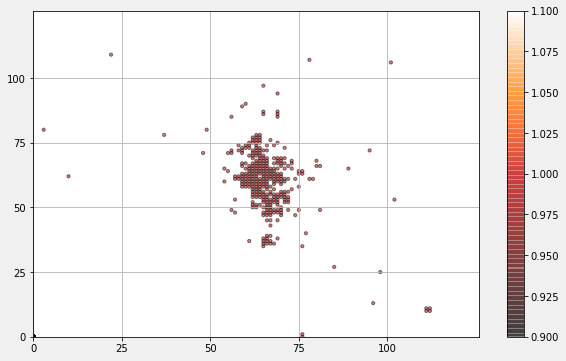

In [109]:
vis(input_data)

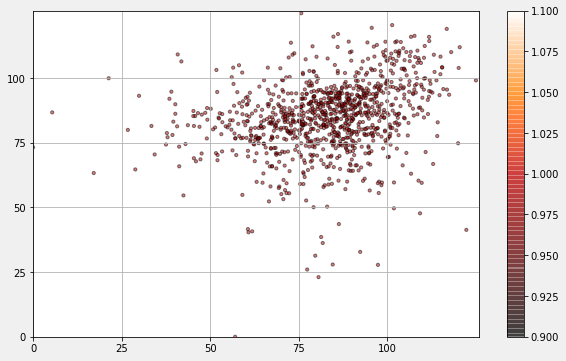

In [110]:
vis(pred)

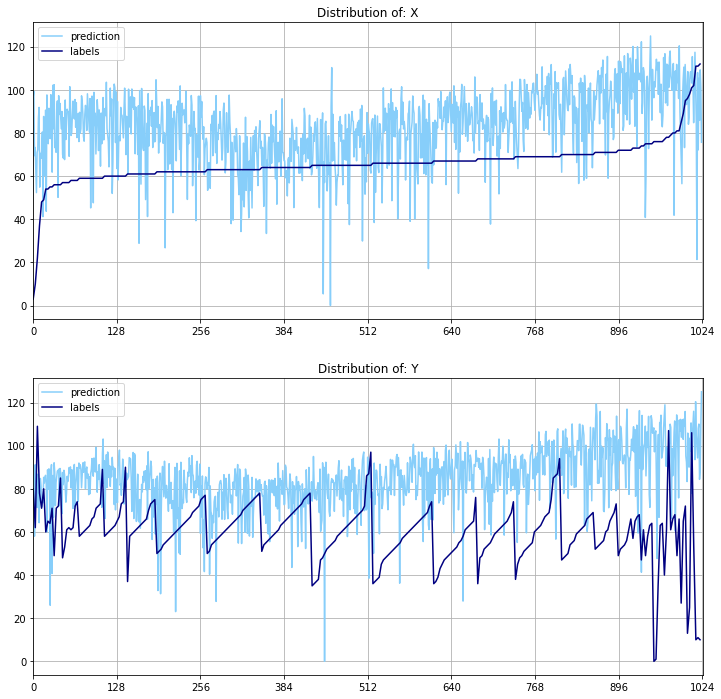

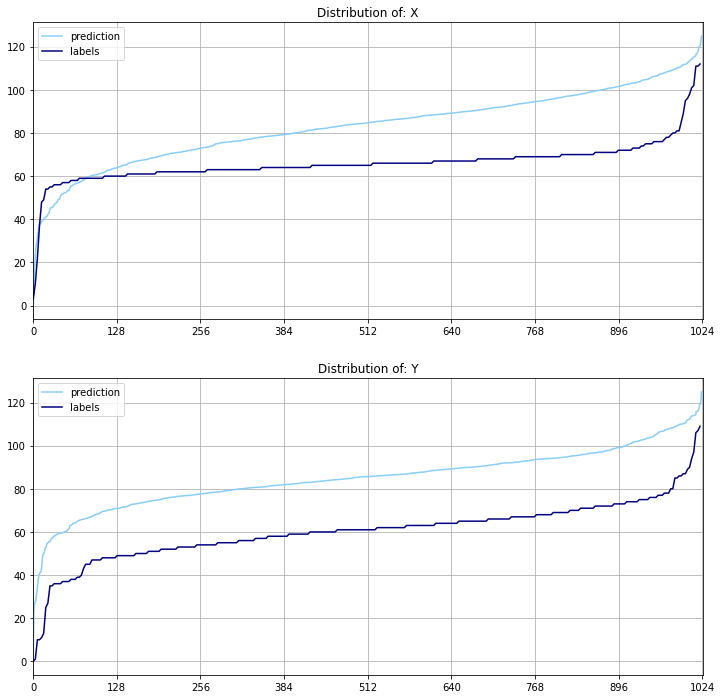

In [111]:
def analyse_prediction(data, pred, to_sort=False):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero()) // 2
    data = data[:n_hits]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))

        if to_sort:
            ax.plot(pred_idx, sorted(pred[:,i]), label='prediction', c='lightskyblue')
            ax.plot(data_idx, sorted(data[:,i]), label='labels', c='navy')
        else:
            ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
            ax.plot(data_idx, data[:,i], label='labels', c='navy')
        
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)
analyse_prediction(input_data, pred, to_sort=True)

In [112]:
import warnings
warnings.filterwarnings('ignore')

# Get Args
args = get_args()

# Set custom args
args.data_dim = 2048
args.hidden_dim = 2048*2   #3072
args.n_steps = 500*2
args.log_interval = 200
args.cuda = 0
args.lr = 0.1
args.step = 0

# Set Seeds
torch.manual_seed(args.seed)
if args.device.type == 'cuda': 
    torch.cuda.manual_seed(args.seed)

# Get Model
model = BNAF(args.data_dim, args.n_hidden, args.hidden_dim).to(args.device)
if args.restore_file:
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    args.step = model_checkpoint['step']

# Save Config
config = 'Parsed args:\n{}\n\n'.format(pprint.pformat(args.__dict__)) + \
            'Num trainable params: {:,.0f}\n\n'.format(sum(p.numel() for p in model.parameters())) + \
            'Model:\n{}'.format(model)

config_path = os.path.join(args.output_dir, 'config.txt')
if not os.path.exists(config_path):
    with open(config_path, 'a') as f:
        print(config, file=f)

# Get Optimizer + Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=args.lr_decay, patience=args.lr_patience, verbose=True)
if args.restore_file:
    optim_checkpoint = torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device)
    optimizer.load_state_dict(optim_checkpoint['optimizer'])
    scheduler.load_state_dict(optim_checkpoint['scheduler'])

# Initialize Dataset 
dataset_file = DATA_ROOT + INPUT_FORMAT.format(0)
dataset = ParquetDataset(dataset_file)

# Define Loss
loss_fn = compute_kl_pq_loss

In [113]:
# Init Wandb
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_NOTES"] = WANDB_DESC
run = wandb.init(project='gnf', config=DEFAULT_CFG, dir=LOGS_ROOT)
wandb.config.update(args)

# Save files for later
! pip freeze > requirements.txt
wandb.save(ROOT + 'requirements.txt')
# wandb.save(config_path)       # TODO: Fix permission issue on Colab.